In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from gplearn.genetic import SymbolicRegressor, SymbolicTransformer
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("car_sales_data.csv")

In [3]:
print("First five rows of dataset: \n")
df.head()

First five rows of dataset: 



,Manufacturer,Model,Engine size,Fuel type,Year of manufacture,Mileage,Price
0,Ford,Fiesta,1.0,Petrol,2002,127300,3074
1,Porsche,718 Cayman,4.0,Petrol,2016,57850,49704
2,Ford,Mondeo,1.6,Diesel,2014,39190,24072
3,Toyota,RAV4,1.8,Hybrid,1988,210814,1705
4,VW,Polo,1.0,Petrol,2006,127869,4101


In [4]:
print("Data informations: \n")
df.info()

Data informations: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Manufacturer         50000 non-null  object 
 1   Model                50000 non-null  object 
 2   Engine size          50000 non-null  float64
 3   Fuel type            50000 non-null  object 
 4   Year of manufacture  50000 non-null  int64  
 5   Mileage              50000 non-null  int64  
 6   Price                50000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 2.7+ MB


In [5]:
print("Data descriptions: \n")
df.describe()

Data descriptions: 



,Engine size,Year of manufacture,Mileage,Price
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.773058,2004.209440,112497.320700,13828.903160
std,0.734108,9.645965,71632.515602,16416.681336
min,1.000000,1984.000000,630.000000,76.000000
25%,1.400000,1996.000000,54352.250000,3060.750000
50%,1.600000,2004.000000,100987.500000,7971.500000
75%,2.000000,2012.000000,158601.000000,19026.500000
max,5.000000,2022.000000,453537.000000,168081.000000


In [6]:
df_encoded = pd.get_dummies(df, columns=["Fuel type", "Manufacturer", "Model"], drop_first=True)

X = df_encoded.drop(columns=["Price"])
y = df_encoded["Price"]

X[["Year of manufacture"]] = 2025 - X[["Year of manufacture"]]
X = X.rename(columns={'Year of manufacture': 'Age of car'})

X[["Engine size", "Mileage", "Age of car"]] = (
            (X[["Engine size", "Mileage", "Age of car"]] - X[["Engine size", "Mileage", "Age of car"]].mean()) /
            X[["Engine size", "Mileage", "Age of car"]].std())
# y = (y - y.mean()) / y.std()
y = np.log(y)

In [7]:
function_set = ['add', 'sub', 'mul', 'div',
                'sqrt', 'log', 'abs', 'neg', 'inv',
                'max', 'min']
transformer = SymbolicTransformer(generations=20,
                                  population_size=5000,
                                  hall_of_fame=100,
                                  n_components=10,
                                  function_set=function_set,
                                  parsimony_coefficient=0.0001,
                                  max_samples=0.9,
                                  verbose=1,
                                  random_state=42,
                                  n_jobs=-1)

transformer.fit(X, y)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.58         0.101002        3         0.923891          0.92545      1.94m
   1    10.34         0.453861        5         0.949635         0.950485      1.33m
   2     4.50         0.753244        7         0.960214         0.958976      1.17m
   3     5.56         0.821689       25         0.972788         0.971633      1.06m
   4     7.17         0.838838        7         0.978507         0.977992      1.00m
   5     9.96           0.8694       19         0.982133         0.983122     59.01s
   6    15.01         0.852151       20          0.98794         0.987374     59.29s
   7    17.65         0.855485       37         0.991575         0.991155     57.92s
   8    19.75          0.87249       16         0.992154         0.991935  

SymbolicTransformer(function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                                  'abs', 'neg', 'inv', 'max', 'min'],
                    max_samples=0.9, n_jobs=-1, parsimony_coefficient=0.0001,
                    population_size=5000, random_state=42, verbose=1)

In [8]:
X_transformed = transformer.transform(X)
X = np.hstack((X, X_transformed))
X = pd.DataFrame(X_transformed)
X.head()

,0,1,2,3,4,5,6,7,8,9
0,6.848919,-5.642271,-7.848919,-5.413218,-9.566731,7.848919,9.566731,5.848919,-2.924459,8.055566
1,-14.007931,14.245047,12.007931,10.989181,20.249012,-13.007931,-20.249012,-14.007931,7.003965,-13.770815
2,-6.682005,6.658624,5.682005,5.643634,9.499626,-6.682005,-8.499626,-6.682005,3.841002,-6.705385
3,11.138408,-9.765893,-12.138408,-8.122156,-15.835097,11.138408,15.835097,11.138408,-5.764501,12.510922
4,5.221967,-4.007377,-6.221967,-4.193004,-7.118360,6.221967,7.118360,5.221967,-2.110984,6.436558


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [10]:
est_gp = SymbolicRegressor(
    population_size=5000,
    generations=20,
    const_range=(-1, 1),
    p_crossover=0.7,
    p_subtree_mutation=0.1,
    p_hoist_mutation=0.1,
    p_point_mutation=0.1,
    max_samples=0.9,
    verbose=1,
    tournament_size=20,
    parsimony_coefficient=0.001,
    stopping_criteria=0.01,
    metric='mse',
    n_jobs=-1,
    random_state=42
)

est_gp.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    26.80      2.08591e+35        7          48.9818           48.713     44.91s
   1     6.69      2.40753e+14        7          37.0202          36.6501     46.06s
   2     6.22      1.17165e+11        9          33.6434           33.551     49.33s
   3     7.40      2.50408e+06       13          19.3723          19.1384     52.29s
   4    10.08      7.21033e+09       17           11.985          12.0729     46.10s
   5    13.97      1.50667e+10       25           2.7737          2.76453     44.81s
   6    19.62      2.07376e+06       27          1.92856          1.90889     44.80s
   7    23.97       2.3231e+10       27          1.92979           1.8978     44.70s
   8    25.82      6.62915e+06       27          1.46896          1.46139  

SymbolicRegressor(const_range=(-1, 1), max_samples=0.9, metric='mse', n_jobs=-1,
                  p_crossover=0.7, p_hoist_mutation=0.1, p_point_mutation=0.1,
                  p_subtree_mutation=0.1, population_size=5000, random_state=42,
                  stopping_criteria=0.01, verbose=1)

In [11]:
y_pred_train = pd.Series(est_gp.predict(X_train), index=X_train.index)
y_pred_train.head()

18306     8.037075
49528     8.667001
44745     9.887037
46827    10.188121
27531    10.080340
dtype: float64

In [12]:
y_train.head()

18306     8.165364
49528     8.751633
44745    10.023047
46827    10.124469
27531    10.058952
Name: Price, dtype: float64

In [13]:
y_pred_test = pd.Series(est_gp.predict(X_test), index=X_test.index)
y_pred_test.head()

33553    11.050239
9427     10.580949
199       9.713606
12447     8.262964
39489     8.434098
dtype: float64

In [14]:
y_test.head()

33553    11.136004
9427     10.470958
199       9.762500
12447     8.074960
39489     8.483016
Name: Price, dtype: float64

In [15]:
print("Score of Train Samples: %", est_gp.score(X_train, y_train) * 100)
print("Score of Test Samples: %", est_gp.score(X_test, y_test) * 100)

Score of Train Samples: % 99.00358475167859
Score of Test Samples: % 98.99260529448858


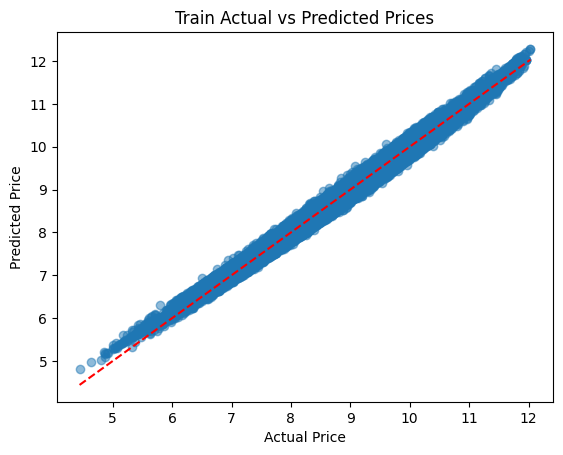

In [16]:
plt.scatter(y_train, y_pred_train, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Train Actual vs Predicted Prices')
plt.show()

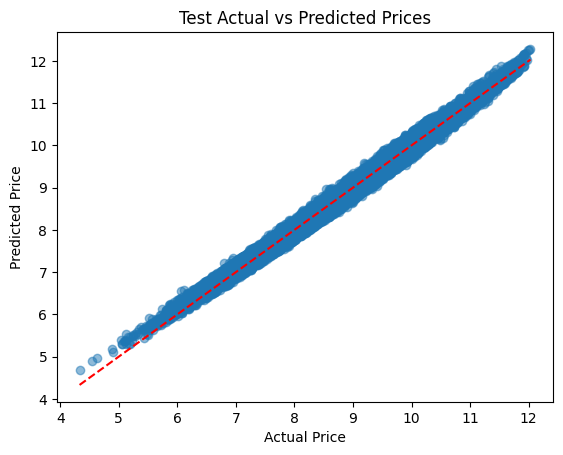

In [17]:
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Test Actual vs Predicted Prices')
plt.show()